In [1]:
import scipy.stats as st
import pylab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import entropy as kl_div, kstest

# 4. Fitting a distribution with Fitter

Fitter is a python library that utilizes the Scipy library's distribution to graph and calculate metrics for goodness of fit.

For the source code, please refer to the [github repository](https://github.com/cokelaer/fitter)

In [2]:
df = pd.read_csv('data/sample_claims.csv')

In [3]:
# f = Fitter(df)
# f.fit()
# f.summary()

We can use the Fitter API to see how well an exponential distribution fits the observed data.

All calculations below can be replicated and validated using the Fitter source code provided in the github link above. The Fitter package abstracts all the logic away, but it  is good to understand the underlying concepts and implementation of the various tests using the exponential distribution as an example.

Note that Fitter comes with some evaluation metrics for goodness of fit which will be covered later. These include:

- sum of squared errors
- information criterion
- kullback-leibler information
- kolmogorov-smirnov test
- chi square test (not included)

scipy.stats.expon


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,8.627424e-08,3575.446841,-1990.559271,inf,0.18499,0.002388


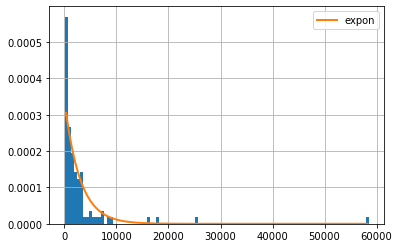

In [4]:
exp_fit = Fitter(df, distributions=["expon"])
exp_fit.fit()
exp_fit.summary()

Numpy histogram function returns a tuple of the observed frequencies and the edges of the bin

We then adjust the x values to the mid-point of the edges using a list comprehension


In [8]:
y, x = np.histogram(df, bins=100, density=True)
x = [(bin_edge_value + x[i + 1]) / 2.0 for i, bin_edge_value in enumerate(x[0:-1])]

Once we've defined our bin values and frequencies, we proceed to fit the data with an exponential distribution using the [Scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html). The underlying object [rv_continuous.fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit) utilizes the maximum likelihood estimate (MLE) algorithm detailed in the previous notebook as a default, but method of moments (MOM) is available as well.

The fit method returns a tuple containing general optimized location and scale parameters, which depending on the chosen distribution, can be solved in a system of equations to obtain the distributional parameters.

In [9]:
params = st.expon.fit(df)

fitted_pdf = st.expon.pdf(x, *params)

print(f'location parameter: {params[0]}')
print(f'scale parameter: {params[-1]}')
print(f'lambda: {1 / params[-1]}')

location parameter: 24.0
scale parameter: 2965.8333333333335
lambda: 0.00033717336330429894


If the exponential distribution is parameterized as follows:

$ f_{x}(X) = \lambda e^{-\lambda x} $

Then following from notebook 2, the `scale` parameter would be $ \dfrac{1}{\beta} $ and given our choice of fit, we can say that we think the underlying distribution generating the data follows $~Exp(\lambda = 0.00034)$.

If we subscribe to this assumption, we can start to make very powerful inferences about the data as follows below.

In [7]:
print(f'probability of observing a claim < $5000 is: {np.round(st.expon.cdf(5000, *params), 2)}')
print(f'probability of observing a claim < $3000 is: {np.round(st.expon.cdf(3000, *params), 2)}')
print(f'probability of observing a claim between $3000 and $5000 is: {np.round(st.expon.cdf(5000, *params) - np.round(st.expon.cdf(3000, *params), 2), 2)}')

probability of observing a claim < $5000 is: 0.81
probability of observing a claim < $3000 is: 0.63
probability of observing a claim between $3000 and $5000 is: 0.18


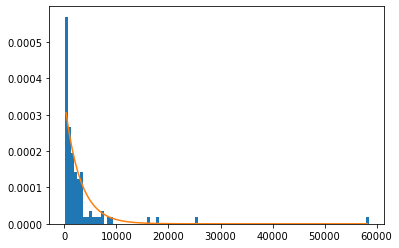

In [8]:
pylab.hist(df, bins=100, density=True)
pylab.plot(x, fitted_pdf)

But, how do we know if our assumptions are 'good' or not? This is where goodness of fit testing would come in.

## Evaluating the goodness of fit

While all these tests (excluding chi square) comes out of the box with the Fitter library, it is good to get a conceptual understanding of the logic and how to implement it manually.

Note that all these metrics are relative measures and provide information when comparing between different fits/models. Absolute standalone values from these metrics rarely provide enough information to make informed decisions regarding model selection.

One common pattern to note is that in many of the tests and formulae, a $ log(\tilde{L}) $ is usually seen in the calculations. This is because when multiplying small numbers repeatedly, the results tend to get rounded to 0. Thus, a log transformation is applied to allow for additions during algebraic manipulation without compromising the extrema of the distribution functions. 

### Sum of squared errors

Sum of square errors is a measure of quadratic loss, and is a commonly used metric which is also referred to as the L2 loss.

$ SSE = \Sigma (x_{pred} - x_{actual})^2$


Note that SSE metric would be impacted materially with outlier values, which would suggest that more attention be put into cleaning up the data before fitting when using this method. Obviously when using SSE, a lower results suggests a better fit.

In [9]:
sq_error = pylab.sum((fitted_pdf - y) ** 2)

print(f'Sum of squared errors: {sq_error}')

Sum of squared errors: 8.627423773657961e-08


### Information criterion

The `Akaike` and `Bayesian` information criterion metrics (AIC and BIC) aim to help users select from a set of models, and uses the likelihood function as a starting point and adding penalizing terms based on the number of parameters of the model and observations.

$ AIC = -2ln(\tilde{L}) + 2k $

$ BIC = -2ln(\tilde{L}) + kln(N) $

Where k is the model degrees of freedom, and N is the number of observations. In both these measures, a lower result represents a better fit. While these measures look similar, the penalization terms results in different motivations behind the selections.

Generally, AIC presents the danger that a model overfits the data as more degrees of freedom in the observed model would result in a lousier score. BIC on the other hand presents the danger of underfitting the data given the errors from the likelihood are added to the size of the data. 

In [10]:
logLik = np.sum(st.expon.logpdf(x, *params))
k = len(params)
n = len(df)
aic = 2 * k - 2 * logLik
bic = n * np.log(sq_error / n) + k * np.log(n)

print(f'AIC: {aic}')
print(f'BIC: {bic}')

AIC: 3575.446841073396
BIC: -1990.5592711125862


### Kullback Leiblier divergence

The KL divergence is a measure that aims to quantify `statistical distance` between 2 probability distributions. Given a random variable X that represents our observations, a starting point to measure difference between 2 distributions p and q would be:

$ \Delta_{x_i}(p, q) = log(p_{\theta}(x_i)) - log(q_{\phi}(x_i)) $

$ \Delta_{x_i}(p, q) =  log\bigg(\dfrac{p_{\theta}(x_i)}{q_{\phi}(x_i)}\bigg) = log(likelihood ratio) $

Now that we have a measure of difference between 2 distributions for a single data point, we need to extend this concept to get the expectation across all data points.

$ \Delta(p, q) =  \int p_{\theta}(x_i) log\bigg(\dfrac{p_{\theta}(x_i)}{q_{\phi}(x_i)}\bigg) dx $

Note that depending on whether p or q is in the denominator, the KL divergence measure would result in a different answer, making it asymmetric. This leads to controversy around actually calling this a distance measure as opposed to a divergence instead.

The choice of reference and approximate distributions lead to different results and application of reverse KL (q in the numerator) can be observed in ML models when evaluating cross entropy.

For more information please refer to the [Scipy kl_div documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html).

In [11]:
# Adjust 0 values to a small number to prevent div 0 errors when calculating KL divergence

y[y == 0] = 0.0001

kullback_leibler = kl_div(fitted_pdf, y)

print(f'kl divergence is: {kullback_leibler}')

kl divergence is: 1.743687567240447


Again, note that a standalone number as above doesn't provide too much context. This must be used in conjunction with other KL divergence figures on different distributions for comparison.

### Kolmogorov-Smirnov test

The KS test is used when wanting to know how well the distribution of the observed data conforms to some theoretical distribution, and uses the cumulative  distribution functions (CDF) as a basis of comparison. The hypotheses of the KS test can be summarized as follows:

$ H_0 $ : Two samples drawn from populations with the same distribution

$ H_1$ : Two samples drawn from populations with different distributions

The test statistic is commonly known as D and can be defined as follows:

$ D = sup|F_{S}(X) - F_{T}(X)| $

The T represents the theoretical distribution and S is the observed sample. This means that the test statistic represents the greatest distance between the 2 CDFs, and is assumed to follow the Kolmogorov distribution. Depending on the value of D, we can get p-values to assess the probability of observing the max distance between our data's CDF and the theoretical one given the null hypothesis is true.

In the example below, we see that D=0.18 and the probability of observing this given the 2 distributions are the same is ~0.2%. At a 95% confidence level, we would reject the null hypothesis that the 2 distributions are the same since 0.2% < 5%.

In [73]:
# weird issue occurring without converting explicitly to int from the pandas dataframe
# to check out scipy ktest source code https://github.com/scipy/scipy/blob/v1.9.1/scipy/stats/_stats_py.py#L7889-L8039

_data = np.array([x for x in df['claims']]).astype(int)

dist_fitted = st.expon(*params)
ks_stat, ks_pval = kstest(_data, dist_fitted.cdf)

print(f'ks statistic D: {ks_stat}')
print(f'probability of observing this value given H0 is true: {ks_pval}')

ks statistic D: 0.18499042546927535
probability of observing this value given H0 is true: 0.0023880598948170517


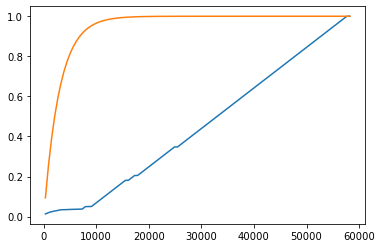

In [74]:
data_pdf = y / sum(y)
data_cdf = np.cumsum(data_pdf)
plt.plot(x, data_cdf, label="CDF")
plt.plot(x, dist_fitted.cdf(x))

In [76]:
sum(y)

0.04220940170940174